# 1 . Introduction

> A concise overview of the FaceSwap project and why CycleGAN is the right tool.

## Project overview
- **Task**: Unpaired face-to-face translation—transform any image from **Domain A** (my face set) into the visual style of **Domain B** (Ryan Reynolds) and vice-versa.
- **Input**: 3k training images per domain, collected & augmented; no pixel-aligned pairs.
- **Output**: Two generators (A → B, B → A) capable of high-fidelity, identity-preserving swaps.

## Goals
1. Achieve visually convincing swaps with minimal artifacts.
2. Maintain facial structure & expression consistency after translation and reconstruction (cycle).

## What is CycleGAN?
- **Architecture**: Two generators *G*<sub>A→B</sub>, *G*<sub>B→A</sub> and two discriminators *D*<sub>B</sub>, *D*<sub>A</sub>.
- **Key losses**
  - *Adversarial* — make translated images indistinguishable from target domain.
  - *Cycle-consistency* — enforce *G*<sub>B→A</sub>(*G*<sub>A→B</sub>(A)) ≈ A (and vice versa).
  - *Identity* (optional) — encourage colour/lighting preservation on same-domain inputs.
- **Advantage**: Learns domain mapping **without paired data**, perfect for real-world FaceSwap where paired photos seldom exist.

## Motivation for using CycleGAN in FaceSwap
- Handles **unpaired datasets** gracefully—collecting aligned A/B faces is impractical.
- Cycle loss keeps distinctive facial geometry (eyes, jawline) intact.
- Proven success in style & identity transfer tasks (horse ↔ zebra, Monet ↔ photo).
- Lightweight compared to large diffusion models—fits on a single RTX 4060 Ti.



# 2. Environment Setup

In [2]:
# =============================================================================
#  FaceSwap - CycleGAN | Consolidated Imports
#  --------------------------------------------------------
#  All external libraries are imported here once.
# =============================================================================

# ---------- Standard-library utilities ----------
import os                       # Path manipulations, directory creation
import shutil                   # File copy / move operations
import random                   # Random sampling, reproducible shuffling
import sys
import importlib.util

# ---------- Numerical & data handling ----------
import numpy as np              # Fast numerical computations & arrays

# ---------- Visualization ----------
import matplotlib.pyplot as plt # Plotting images, loss curves, etc.
from pathlib import Path
import pandas as pd

# ---------- Progress bars ----------
from tqdm import tqdm           # Beautiful progress bars for loops

# ---------- Deep-Learning / PyTorch stack ----------
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torch import amp            # Mixed-precision training utilities
from torch.amp import autocast, GradScaler
from torchvision import transforms
from torchvision.utils import make_grid, save_image
from torchvision.datasets import ImageFolder


# ---------- Computer-Vision helpers ----------
import cv2                      # OpenCV: image I/O & processing (BGR)
from PIL import ImageEnhance    # Pillow: image file handling & basic ops
import mediapipe as mp          # Face detection / landmarks

# ---------- Image preprocessing extras ----------
from rembg import remove        # Background removal on RGBA images

# ---------- Device configuration ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:

def get_project_root() -> Path:
    """Return project root whether running as notebook or script."""
    try:      # ← inside .py script
        return Path(__file__).resolve().parent
    except NameError:   # ← inside Jupyter
        return Path.cwd().resolve()

# ---------- Core folders ----------
PROJECT_ROOT = get_project_root()

DATASETS_DIR = PROJECT_ROOT / 'datasets'      # CycleGAN A/B domains
RAW_DATA_DIR = PROJECT_ROOT / 'raw_data'      # Original, unprocessed images
CHECKPOINT_DIR = PROJECT_ROOT / 'checkpoints' # *.pth snapshots / best weights
MODEL_DIR   = PROJECT_ROOT / 'saved_models'   # Extra exported models (if any)

# ---------- CycleGAN domain splits ----------
TRAIN_A_DIR = DATASETS_DIR / 'trainA'
TRAIN_B_DIR = DATASETS_DIR / 'trainB'
VAL_A_DIR  = DATASETS_DIR / 'valA'
VAL_B_DIR  = DATASETS_DIR / 'valB'
TEST_A_DIR  = DATASETS_DIR / 'testA'
TEST_B_DIR  = DATASETS_DIR / 'testB'

# ---------- Commonly-used file paths ----------
BEST_G_AB_PATH = CHECKPOINT_DIR / 'best_G_AB.pth'
BEST_G_BA_PATH = CHECKPOINT_DIR / 'best_G_BA.pth'
NOTEBOOK_PATH  = PROJECT_ROOT / 'FaceSwap (CycleGAN).ipynb'

# ---------- Utility: make sure folders exist ----------
for p in [DATASETS_DIR, RAW_DATA_DIR, CHECKPOINT_DIR, MODEL_DIR,
          TRAIN_A_DIR, TRAIN_B_DIR, TEST_A_DIR, TEST_B_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print(f"✅ Paths initialised under {PROJECT_ROOT}")


✅ Paths initialised under C:\Users\YehonatanR\OneDrive\Documents\HIT Computer Science\3rd\Computer_Vision\FinalProject


In [4]:
import torch
import torchvision

print("Torch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version (compiled):", torch.version.cuda)
print("Current device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

Torch version: 2.6.0+cu126
Torchvision version: 0.21.0+cu126
CUDA available: True
CUDA version (compiled): 12.6
Current device: NVIDIA GeForce RTX 4060 Ti


# 3. Data Preparation

In [ ]:
def rename_files(folder_path, start_index=1,temp_prefix="__temp__file__"):
    """
    Renames all image files in folder_path to consecutive numbers, keeping original extensions.
    Ensures there are no name collisions. Does not modify file contents.
    """
    # Allowed file extensions
    valid_exts = ('.jpg', '.jpeg', '.png', '.webp', '.avif')
    file_list = [f for f in os.listdir(folder_path) if f.lower().endswith(valid_exts)]
    temp_names = []

    # Step 1: Temporarily rename all files to avoid name collisions
    for i, old_name in enumerate(file_list):
        old_path = os.path.join(folder_path, old_name)
        temp_name = f"{temp_prefix}{i}{os.path.splitext(old_name)[1]}"
        temp_path = os.path.join(folder_path, temp_name)
        os.rename(old_path, temp_path)
        temp_names.append(temp_name)

    # Step 2: Final renaming with sequential numbering
    current_index = start_index
    for temp_name in sorted(temp_names):
        old_path = os.path.join(folder_path, temp_name)
        ext = os.path.splitext(temp_name)[1].lower()
        new_name = f"{current_index}{ext}"
        new_path = os.path.join(folder_path, new_name)

        # If a file with the new name already exists, skip to the next available number
        while os.path.exists(new_path):
            current_index += 1
            new_name = f"{current_index}{ext}"
            new_path = os.path.join(folder_path, new_name)

        os.rename(old_path, new_path)
        current_index += 1

    print(f"✅ Renamed {current_index - start_index} files in '{folder_path}' without changing contents.")


In [ ]:
# rename_files(
#     folder_path=TRAIN_B_DIR,
#     start_index=1
# )

In [ ]:
from PIL import Image
def crop_face_area(image_rgba, scale=1.8):
    """
    Detect face and crop surrounding area with padding.

    Args:
        image_rgba (PIL.Image): Image with RGBA channels.
        scale (float): Controls padding around face. Higher = more context (hair/shoulders).

    Returns:
        PIL.Image: Cropped image focused around face.
    """
    img_bgr = cv2.cvtColor(np.array(image_rgba), cv2.COLOR_RGBA2BGR)
    h, w = img_bgr.shape[:2]

    detector = mp.solutions.face_detection.FaceDetection(model_selection=1)
    results = detector.process(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))

    if not results.detections:
        return image_rgba  # fallback if no face is detected

    bbox = results.detections[0].location_data.relative_bounding_box
    x = int(bbox.xmin * w)
    y = int(bbox.ymin * h)
    bw = int(bbox.width * w)
    bh = int(bbox.height * h)

    cx, cy = x + bw // 2, y + bh // 2
    max_side = int(max(bw, bh) * scale)
    x1 = max(cx - max_side // 2, 0)
    y1 = max(cy - max_side // 2, 0)
    x2 = min(cx + max_side // 2, w)
    y2 = min(cy + max_side // 2, h)

    return image_rgba.crop((x1, y1, x2, y2))


def crop_faces_in_folder(input_dir, output_dir, scale=1.8):
    """
    Crop face areas from images in a folder and save as high-quality JPEG.
    """
    os.makedirs(output_dir, exist_ok=True)
    files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    for fname in tqdm(files, desc="Cropping faces", dynamic_ncols=True):
        input_path = os.path.join(input_dir, fname)
        output_path = os.path.join(output_dir, os.path.splitext(fname)[0] + ".jpg")

        try:
            img = Image.open(input_path).convert("RGBA")
            cropped_img = crop_face_area(img, scale=scale)
            cropped_img.convert("RGB").save(output_path, format="JPEG", quality=100, subsampling=0)
        except Exception as e:
            print(f"❌ Error processing {fname}: {e}")


In [ ]:
# crop_faces_in_folder(input_dir=TRAIN_B_DIR,
#                      output_dir=TRAIN_B_DIR,
#                      scale=1.8)

In [ ]:
def remove_bg_and_sharpen_folder(input_dir, output_dir, bg_color=(255,255,255), sharpen_factor=1.5, out_format='JPEG'):
    """
    Removes background and sharpens all images in input_dir.
    Saves processed images with the same name to output_dir.
    Args:
        input_dir (str): Folder containing the original images.
        output_dir (str): Where to save processed images.
        bg_color (tuple): Background color for compositing if JPEG.
        sharpen_factor (float): Intensity for sharpening.
        out_format (str): 'JPEG' or 'PNG'.
    """
    os.makedirs(output_dir, exist_ok=True)
    valid_exts = ('.jpg', '.jpeg', '.png', '.webp')

    files = [f for f in os.listdir(input_dir) if f.lower().endswith(valid_exts)]

    for fname in tqdm(files, desc="Removing background & sharpening", dynamic_ncols=True):
        input_path = os.path.join(input_dir, fname)
        output_path = os.path.join(output_dir, os.path.splitext(fname)[0] + ('.jpg' if out_format.upper() == 'JPEG' else '.png'))
        try:
            img = Image.open(input_path).convert("RGBA")
            no_bg = remove(img)

            if out_format.upper() == "JPEG":
                bg = Image.new("RGBA", no_bg.size, bg_color + (255,))
                composited = Image.alpha_composite(bg, no_bg)
            else:
                composited = no_bg

            composited = ImageEnhance.Sharpness(composited).enhance(sharpen_factor)

            if out_format.upper() == "JPEG":
                composited = composited.convert("RGB")
                composited.save(output_path, format="JPEG", quality=100, subsampling=0)
            else:
                composited.save(output_path, format="PNG", compress_level=0)

        except Exception as e:
            print(f"❌ Error processing {fname}: {e}")


In [ ]:
# remove_bg_and_sharpen_folder(
#     input_dir=TRAIN_A_DIR,
#     output_dir=TRAIN_A_DIR / "_clean",
#     bg_color=(255,255,255),
#     sharpen_factor=1.6,
#     out_format='JPEG'
# )

In [ ]:
def augment_images(input_dir, output_dir, augmentations_per_image=2):
    """
    Applies N random augmentations per image (no resize) and saves them to output_dir.

    Args:
        input_dir (str): Path to folder with original images
        output_dir (str): Path to folder to save augmented images
        augmentations_per_image (int): Number of augmentations to apply per image
    """
    os.makedirs(output_dir, exist_ok=True)

    # Define available augmentations (pure augmentations only, no resize)
    augmentation_ops = [
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
        transforms.RandomAffine(degrees=5, translate=(0.05, 0.05))
    ]

    image_files = [
        f for f in os.listdir(input_dir)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]

    for filename in image_files:
        img_path = os.path.join(input_dir, filename)
        try:
            img = Image.open(img_path).convert("RGB")
        except:
            print(f"❌ Skipped unreadable file: {filename}")
            continue

        base_name = os.path.splitext(filename)[0]

        for i in range(augmentations_per_image):
            # Select 2 random augmentations from the pool
            chosen_augs = random.sample(augmentation_ops, k=2)
            aug_pipeline = transforms.Compose(chosen_augs)
            aug_img = aug_pipeline(img)

            save_path = os.path.join(output_dir, f"{base_name}_aug{i+1}.jpg")
            aug_img.save(save_path)

    print(f"✅ Done: {len(image_files)} images × {augmentations_per_image} augmentations saved to: {output_dir}")


In [ ]:
# augment_images(
#     input_dir=TRAIN_B_DIR,
#     output_dir=TRAIN_B_DIR,
#     augmentations_per_image=2
# )

In [ ]:
def split_val(source_dir, val_dir, val_ratio=0.1, seed=42):
    """
    Moves a random subset of images from source_dir to val_dir.

    Args:
        source_dir (str): Path to the train folder (images will be moved from here).
        val_dir (str): Path where validation images will be moved.
        val_ratio (float): Fraction of images to use as validation (e.g. 0.1 for 10%).
        seed (int): Random seed for reproducibility.
    """
    os.makedirs(val_dir, exist_ok=True)

    valid_exts = ('.jpg', '.jpeg', '.png', '.webp')
    all_images = [f for f in os.listdir(source_dir) if f.lower().endswith(valid_exts)]
    random.seed(seed)
    random.shuffle(all_images)

    val_count = int(len(all_images) * val_ratio)
    val_images = all_images[:val_count]

    for fname in val_images:
        src = os.path.join(source_dir, fname)
        dst = os.path.join(val_dir, fname)
        shutil.move(src, dst)

    print(f"✅ Moved {val_count} val images from {source_dir} → {val_dir}")


In [ ]:
# split_val(
#     source_dir=TRAIN_B_DIR / "images",
#     val_dir=VAL_B_DIR,
#     val_ratio=0.1
# )

In [ ]:
def split_test(source_dir, test_dir, test_ratio=0.1, seed=42):
    """
    Moves a random subset of images from source_dir to test_dir.

    Args:
        source_dir (str): Path to the train folder (images will be moved from here).
        test_dir (str): Path where test images will be moved.
        test_ratio (float): Fraction of images to use as test (e.g. 0.1 for 10%).
        seed (int): Random seed for reproducibility.
    """
    os.makedirs(test_dir, exist_ok=True)

    valid_exts = ('.jpg', '.jpeg', '.png', '.webp')
    all_images = [f for f in os.listdir(source_dir) if f.lower().endswith(valid_exts)]
    random.seed(seed)
    random.shuffle(all_images)

    test_count = int(len(all_images) * test_ratio)
    test_images = all_images[:test_count]

    for fname in test_images:
        src = os.path.join(source_dir, fname)
        dst = os.path.join(test_dir, fname)
        shutil.move(src, dst)

    print(f"✅ Moved {test_count} test images from {source_dir} → {test_dir}")


In [ ]:
# split_test(
#     source_dir=TRAIN_B_DIR,
#     test_dir=TEST_B_DIR,
#     test_ratio=0.1
# )

# 4. Exploratory Data Analysis (EDA)

,num_images
trainA,2430
trainB,2430
testA,300
testB,300


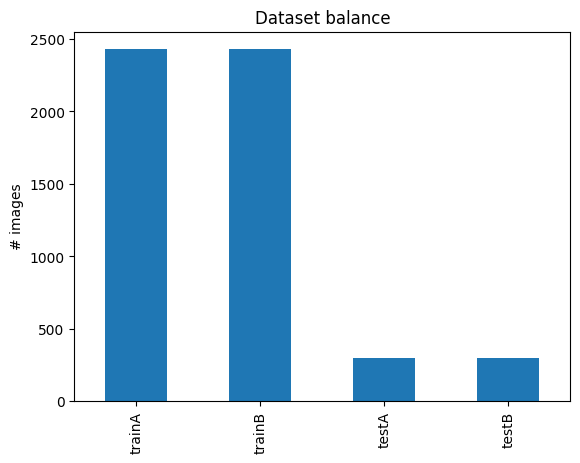

In [5]:
# =========================================================
#  EDA 1 – Count images per domain (trainA/B, testA/B, …)
# =========================================================
DOMAINS = {
    "trainA": TRAIN_A_DIR / "images",
    "trainB": TRAIN_B_DIR / "images",
    "testA":  TEST_A_DIR / "images",
    "testB":  TEST_B_DIR / "images",
}

counts = {name: len(list(p.glob("*.jpg"))) for name, p in DOMAINS.items()}
df_counts = pd.DataFrame.from_dict(counts, orient="index", columns=["num_images"])
display(df_counts)

# Optional – quick bar plot
df_counts.plot(kind="bar", legend=False, ylabel="# images", title="Dataset balance");


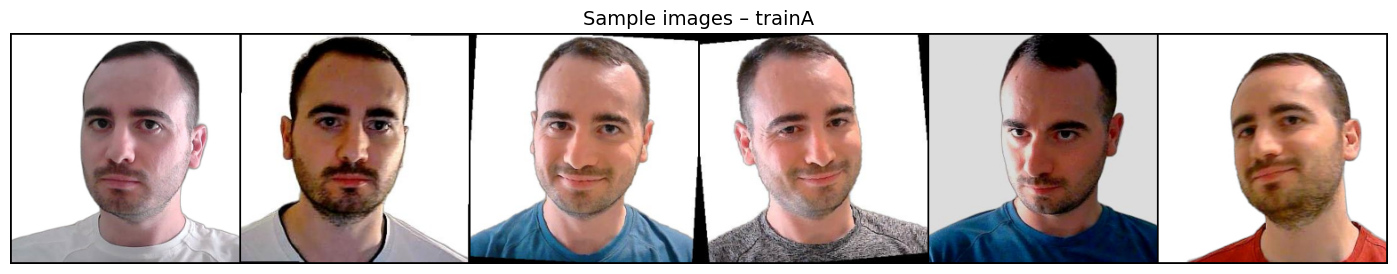

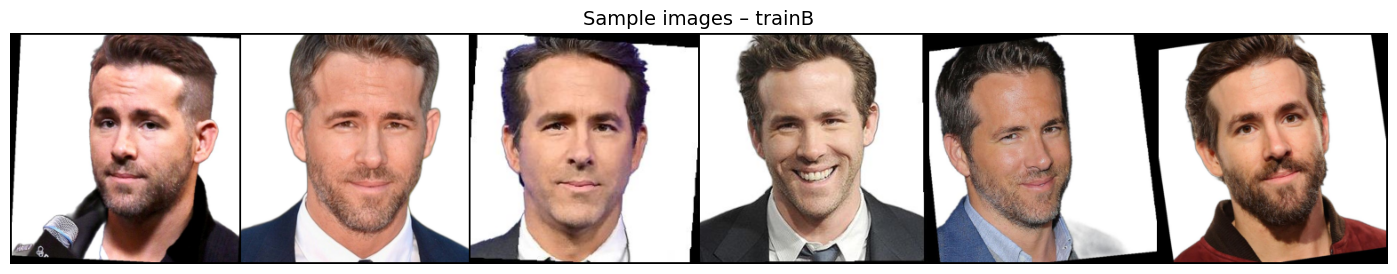

In [9]:
# =========================================================
#  EDA 2 – Show 8 random images from each domain
# =========================================================
from PIL import Image
tfm_vis = transforms.Compose([
    transforms.Resize(256),          # quick thumb (only for EDA)
    transforms.CenterCrop(256),
    transforms.ToTensor(),           # 0-1 floats
])

def show_domain_row(path, n=6, domain_name=""):
    """Show n random images from `path` in a single horizontal row."""
    img_paths = random.sample(list(path.glob("*.jpg")), n)
    tensors = [tfm_vis(Image.open(p).convert("RGB")) for p in img_paths]
    grid = make_grid(tensors, nrow=len(tensors), padding=2)

    img_np = grid.permute(1, 2, 0).cpu().numpy().clip(0, 1)  # H×W×3, [0,1]
    plt.figure(figsize=(3*n, 3))
    plt.imshow(img_np)
    plt.axis("off")
    plt.title(f"Sample images – {domain_name}", fontsize=14)
    plt.show()


# --- Display only the train splits ---
DOMAINS = {
    "trainA": TRAIN_A_DIR / "images",
    "trainB": TRAIN_B_DIR / "images",
}

for name, p in DOMAINS.items():
    show_domain_row(p, n=6, domain_name=name)


In [10]:
mp_face_detection = mp.solutions.face_detection
detector = mp_face_detection.FaceDetection(model_selection=1)

def analyze_dataset(directory):
    cx_list, cy_list, area_list = [], [], []
    files = [f for f in os.listdir(directory) if f.lower().endswith('.jpg')]

    for fname in files:
        img_path = os.path.join(directory, fname)
        img = cv2.imread(img_path)
        if img is None:
            continue

        result = detector.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        if not result.detections:
            continue

        h, w = img.shape[:2]
        bbox = result.detections[0].location_data.relative_bounding_box
        x = int(bbox.xmin * w)
        y = int(bbox.ymin * h)
        bw = int(bbox.width * w)
        bh = int(bbox.height * h)

        cx = (x + bw / 2) / w
        cy = (y + bh / 2) / h
        area_ratio = (bw * bh) / (w * h)

        cx_list.append(cx)
        cy_list.append(cy)
        area_list.append(area_ratio)

    return {
        'count': len(cx_list),
        'cx': (np.mean(cx_list), np.std(cx_list)),
        'cy': (np.mean(cy_list), np.std(cy_list)),
        'area': (np.mean(area_list), np.std(area_list))
    }

# Print comparison
def print_stats(name, stats):
    print(f"📂 {name} ({stats['count']} images)")
    print(f"  📍 cx:    {stats['cx'][0]:.3f} ± {stats['cx'][1]:.3f}")
    print(f"  📍 cy:    {stats['cy'][0]:.3f} ± {stats['cy'][1]:.3f}")
    print(f"  📐 area:  {stats['area'][0]*100:.1f}% ± {stats['area'][1]*100:.1f}%")


📂 trainA (2359 images)
  📍 cx:    0.499 ± 0.020
  📍 cy:    0.499 ± 0.021
  📐 area:  32.8% ± 2.9%
📂 trainB (2259 images)
  📍 cx:    0.500 ± 0.027
  📍 cy:    0.497 ± 0.028
  📐 area:  31.0% ± 4.5%


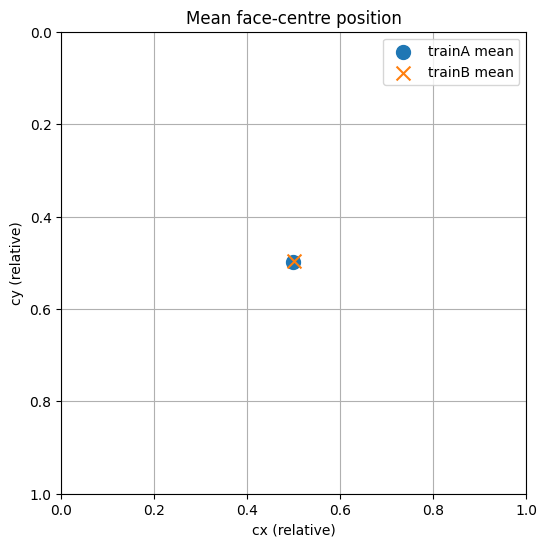

In [12]:
# =========================================================
#  EDA 3 – Bounding-box (cx, cy, area) statistics
# =========================================================
stats_A = analyze_dataset(TRAIN_A_DIR / "images")
stats_B = analyze_dataset(TRAIN_B_DIR / "images")

print_stats("trainA", stats_A)
print_stats("trainB", stats_B)

# Optional scatter of centres
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.scatter(stats_A['cx'][0], stats_A['cy'][0], label='trainA mean', marker='o', s=100)
plt.scatter(stats_B['cx'][0], stats_B['cy'][0], label='trainB mean', marker='x', s=100)
plt.xlim(0,1); plt.ylim(0,1); plt.gca().invert_yaxis()
plt.xlabel("cx (relative)"); plt.ylabel("cy (relative)")
plt.title("Mean face-centre position"); plt.legend(); plt.grid(True); plt.show()


# 5. CycleGAN Architecture

In [5]:
IMG_SIZE = 256

# Define transform: resize, to tensor, normalize to [-1, 1]
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
# Assume directory structure:
# datasets/
#   trainA/
#   trainB/
#   testA/
#   testB/
#   valA/
#   valB/

# For trainA and trainB
dataset_A = ImageFolder(root=TRAIN_A_DIR, transform=transform)
dataset_B = ImageFolder(root=TRAIN_B_DIR, transform=transform)

loader_A = DataLoader(dataset_A, batch_size=4, shuffle=True, num_workers=0)
loader_B = DataLoader(dataset_B, batch_size=4, shuffle=True, num_workers=0)

# For validation sets
valset_A = ImageFolder(root=VAL_A_DIR, transform=transform)
valset_B = ImageFolder(root=VAL_B_DIR, transform=transform)

valloader_A = DataLoader(valset_A, batch_size=4, shuffle=False, num_workers=0)
valloader_B = DataLoader(valset_B, batch_size=4, shuffle=False, num_workers=0)

# For test sets
testset_A = ImageFolder(root=TEST_A_DIR, transform=transform)
testset_B = ImageFolder(root=TEST_B_DIR, transform=transform)

testloader_A = DataLoader(testset_A, batch_size=4, shuffle=False, num_workers=0)
testloader_B = DataLoader(testset_B, batch_size=4, shuffle=False, num_workers=0)


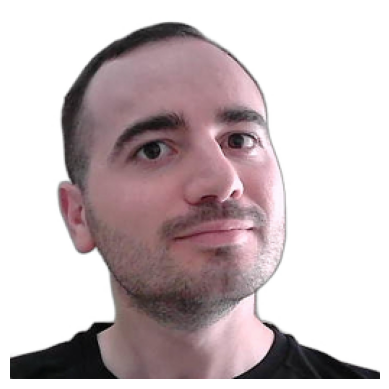

In [7]:
sample, _ = dataset_A[0]
img = sample.permute(1, 2, 0).numpy()  # (H, W, C)
img = (img * 0.5) + 0.5                # Convert from [-1,1] to [0,1]
plt.imshow(np.clip(img, 0, 1))
plt.axis('off')
plt.show()


In [ ]:
# !git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix.git

In [8]:
sys.path.append('pytorch-CycleGAN-and-pix2pix')
sys.path.append('pytorch-CycleGAN-and-pix2pix/models')

In [9]:
module_path = os.path.abspath('pytorch-CycleGAN-and-pix2pix/models/networks.py')
spec = importlib.util.spec_from_file_location("networks", module_path)
networks = importlib.util.module_from_spec(spec)
spec.loader.exec_module(networks)

networks.NLayerDiscriminator

networks.NLayerDiscriminator

In [10]:
netG_A2B = networks.ResnetGenerator(input_nc=3, output_nc=3, n_blocks=9).cuda()
netG_B2A = networks.ResnetGenerator(input_nc=3, output_nc=3, n_blocks=9).cuda()
netD_A   = networks.NLayerDiscriminator(input_nc=3).cuda()
netD_B   = networks.NLayerDiscriminator(input_nc=3).cuda()

In [11]:
optimizer_G = optim.Adam(
    list(netG_A2B.parameters()) + list(netG_B2A.parameters()),
    lr=0.0002, betas=(0.5, 0.999)
)
optimizer_D = optim.Adam(
    list(netD_A.parameters()) + list(netD_B.parameters()),
    lr=0.0002, betas=(0.5, 0.999)
)

In [12]:
def lambda_rule(epoch):
    n_epochs = 100
    n_epochs_decay = 50
    lr_l = 1.0 - max(0, epoch + 1 - n_epochs) / float(n_epochs_decay + 1)
    return lr_l

lr_scheduler_G = optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_rule)
lr_scheduler_D = optim.lr_scheduler.LambdaLR(optimizer_D, lr_lambda=lambda_rule)


In [13]:
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()

scaler = GradScaler(device='cuda')

In [14]:
import torch
from collections import Counter
from tabulate import tabulate

def compact_table(model, title):
    """
    Prints a collapsed summary:  Layer-type | repeats | total params
    """
    layer_cnt  = Counter()
    param_cnt  = Counter()

    for m in model.modules():
        if len(list(m.children())) > 0:        # skip containers (Sequential, etc.)
            continue
        cls = m.__class__.__name__
        layer_cnt[cls]  += 1
        param_cnt[cls]  += sum(p.numel() for p in m.parameters())

    # build sorted rows (largest param budgets first)
    rows = [[cls, f"{layer_cnt[cls]}×", f"{param_cnt[cls]:,}"]
            for cls in layer_cnt]
    rows.sort(key=lambda r: int(r[2].replace(",", "")), reverse=True)

    total = sum(param_cnt.values())
    print(f"\n── {title} – collapsed summary ──")
    print(tabulate(rows,
                   headers=["Layer type", "Repeats", "Total params"],
                   tablefmt="github"))
    print(f"\n**Total trainable params:** {total:,}\n")

# ------------------ use it ------------------
compact_table(netG_A2B, "Generator A → B")
compact_table(netG_B2A, "Generator B → A")
compact_table(netD_A,   "Discriminator A")
compact_table(netD_B,   "Discriminator B")



── Generator A → B – collapsed summary ──
| Layer type      | Repeats   | Total params   |
|-----------------|-----------|----------------|
| Conv2d          | 22×       | 11,004,291     |
| ConvTranspose2d | 2×        | 368,640        |
| BatchNorm2d     | 23×       | 10,496         |
| ReflectionPad2d | 20×       | 0              |
| ReLU            | 14×       | 0              |
| Tanh            | 1×        | 0              |

**Total trainable params:** 11,383,427


── Generator B → A – collapsed summary ──
| Layer type      | Repeats   | Total params   |
|-----------------|-----------|----------------|
| Conv2d          | 22×       | 11,004,291     |
| ConvTranspose2d | 2×        | 368,640        |
| BatchNorm2d     | 23×       | 10,496         |
| ReflectionPad2d | 20×       | 0              |
| ReLU            | 14×       | 0              |
| Tanh            | 1×        | 0              |

**Total trainable params:** 11,383,427


── Discriminator A – collapsed summary ──
| Lay

In [18]:
checkpoint_path = "checkpoints/checkpoint_epoch_160.pth"

checkpoint = torch.load(checkpoint_path, map_location="cuda")

netG_A2B.load_state_dict(checkpoint['netG_A2B'])
netG_B2A.load_state_dict(checkpoint['netG_B2A'])
netD_A.load_state_dict(checkpoint['netD_A'])
netD_B.load_state_dict(checkpoint['netD_B'])
optimizer_G.load_state_dict(checkpoint['optimizer_G'])
optimizer_D.load_state_dict(checkpoint['optimizer_D'])
scaler.load_state_dict(checkpoint['scaler'])
start_epoch = checkpoint['epoch'] + 1


In [35]:
def evaluate_on_validation(netG_A2B, netG_B2A, valloader_A, valloader_B, criterion_cycle, device="cuda"):
    netG_A2B.eval(); netG_B2A.eval()
    cycle_loss_A, cycle_loss_B, n_batches = 0, 0, 0
    with torch.no_grad():
        for (batch_A, _), (batch_B, _) in zip(valloader_A, valloader_B):
            real_A = batch_A.to(device)
            real_B = batch_B.to(device)
            # Cycle A → B → A
            fake_B = netG_A2B(real_A)
            rec_A = netG_B2A(fake_B)
            cycle_loss_A += criterion_cycle(rec_A, real_A).item()
            # Cycle B → A → B
            fake_A = netG_B2A(real_B)
            rec_B = netG_A2B(fake_A)
            cycle_loss_B += criterion_cycle(rec_B, real_B).item()
            n_batches += 1
    return (cycle_loss_A + cycle_loss_B) / (2 * n_batches)


In [36]:
def train_cyclegan_epoch(
    netG_A2B, netG_B2A, netD_A, netD_B,
    loader_A, loader_B,
    valloader_A, valloader_B,
    optimizer_G, optimizer_D,
    scaler,
    criterion_GAN, criterion_cycle,
    lr_scheduler_G, lr_scheduler_D,
    save_dir="checkpoints",
    sample_dir="samples",
    num_epochs=100,
    start_epoch=1,
    checkpoint_freq=5,
    sample_freq=2,
    device="cuda"
):
    """
    CycleGAN training loop: tracks & saves losses, uses validation for best_model, CSV export, tqdm cleaned.
    """

    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(sample_dir, exist_ok=True)

    def denorm(t):
        return torch.clamp((t * 0.5) + 0.5, 0, 1)

    # --- Initialize loss history and best model tracking
    loss_history = {"epoch": [], "G": [], "D_A": [], "D_B": [], "Total": [], "val_metric": []}
    best_val = float('inf')
    best_state = None

    for epoch in range(start_epoch, num_epochs + 1):
        netG_A2B.train(); netG_B2A.train()
        netD_A.train(); netD_B.train()
        running_loss_G, running_loss_D_A, running_loss_D_B, running_loss_total = 0, 0, 0, 0

        loop = tqdm(
            zip(loader_A, loader_B),
            total=min(len(loader_A), len(loader_B)),
            desc=f"Epoch {epoch}/{num_epochs}",
            dynamic_ncols=True,
            leave=False if epoch < num_epochs else True,
            mininterval=0.5  # Update bar no more than twice per second
        )

        for i, (batch_A, batch_B) in enumerate(loop):
            real_A = batch_A[0].to(device)
            real_B = batch_B[0].to(device)

            # === Train Generators ===
            optimizer_G.zero_grad()
            with torch.amp.autocast(device_type="cuda"):
                fake_B = netG_A2B(real_A)
                rec_A = netG_B2A(fake_B)
                fake_A = netG_B2A(real_B)
                rec_B = netG_A2B(fake_A)

                loss_GAN_AB = criterion_GAN(netD_B(fake_B), torch.ones_like(netD_B(fake_B)))
                loss_GAN_BA = criterion_GAN(netD_A(fake_A), torch.ones_like(netD_A(fake_A)))
                loss_cycle_A = criterion_cycle(rec_A, real_A)
                loss_cycle_B = criterion_cycle(rec_B, real_B)

                loss_G = loss_GAN_AB + loss_GAN_BA + 10.0 * (loss_cycle_A + loss_cycle_B)

            scaler.scale(loss_G).backward()
            scaler.step(optimizer_G)
            scaler.update()

            # === Train Discriminators ===
            optimizer_D.zero_grad()
            with torch.amp.autocast(device_type="cuda"):
                loss_D_A_real = criterion_GAN(netD_A(real_A), torch.ones_like(netD_A(real_A)))
                loss_D_A_fake = criterion_GAN(netD_A(fake_A.detach()), torch.zeros_like(netD_A(fake_A)))
                loss_D_A = 0.5 * (loss_D_A_real + loss_D_A_fake)

                loss_D_B_real = criterion_GAN(netD_B(real_B), torch.ones_like(netD_B(real_B)))
                loss_D_B_fake = criterion_GAN(netD_B(fake_B.detach()), torch.zeros_like(netD_B(fake_B)))
                loss_D_B = 0.5 * (loss_D_B_real + loss_D_B_fake)

                loss_D = loss_D_A + loss_D_B

            scaler.scale(loss_D).backward()
            scaler.step(optimizer_D)
            scaler.update()

            # Track running losses for this batch
            running_loss_G += loss_G.item()
            running_loss_D_A += loss_D_A.item()
            running_loss_D_B += loss_D_B.item()
            running_loss_total += (loss_G.item() + loss_D.item())

            # Update bar only sometimes to reduce clutter
            if (i % 10 == 0) or (i == len(loop) - 1):
                loop.set_postfix(G=f"{loss_G.item():.2f}", D_A=f"{loss_D_A.item():.2f}", D_B=f"{loss_D_B.item():.2f}")

        # Compute and store epoch averages
        n_batches = min(len(loader_A), len(loader_B))
        avg_loss_G = running_loss_G / n_batches
        avg_loss_D_A = running_loss_D_A / n_batches
        avg_loss_D_B = running_loss_D_B / n_batches
        avg_loss_total = running_loss_total / n_batches

        # --- Validation metric on val set
        val_metric = evaluate_on_validation(netG_A2B, netG_B2A, valloader_A, valloader_B, criterion_cycle, device)

        # --- Save losses
        loss_history["epoch"].append(epoch)
        loss_history["G"].append(avg_loss_G)
        loss_history["D_A"].append(avg_loss_D_A)
        loss_history["D_B"].append(avg_loss_D_B)
        loss_history["Total"].append(avg_loss_total)
        loss_history["val_metric"].append(val_metric)

        lr_scheduler_G.step()
        lr_scheduler_D.step()

        # Display and Save Samples
        if (epoch <= 5) or (epoch % sample_freq == 0):
            netG_A2B.eval(); netG_B2A.eval()
            with torch.no_grad():
                real_A = next(iter(loader_A))[0].to(device)
                fake_B = netG_A2B(real_A)
                rec_A = netG_B2A(fake_B)
                grid = make_grid([denorm(real_A[0]), denorm(fake_B[0]), denorm(rec_A[0])], nrow=3)
                plt.figure(figsize=(12,4))
                plt.imshow(grid.permute(1,2,0).cpu().numpy())
                plt.title(f"real_A → fake_B → rec_A (epoch {epoch})")
                plt.axis("off")
                plt.show()
                save_image(grid, os.path.join(sample_dir, f"sample_epoch_{epoch}.png"))
            netG_A2B.train(); netG_B2A.train()

        # Checkpointing (all epochs)
        if epoch % checkpoint_freq == 0:
            torch.save({
                'epoch': epoch,
                'netG_A2B': netG_A2B.state_dict(),
                'netG_B2A': netG_B2A.state_dict(),
                'netD_A': netD_A.state_dict(),
                'netD_B': netD_B.state_dict(),
                'optimizer_G': optimizer_G.state_dict(),
                'optimizer_D': optimizer_D.state_dict(),
                'scaler': scaler.state_dict(),
                'loss_history': loss_history
            }, os.path.join(save_dir, f"checkpoint_epoch_{epoch}.pth"))

        # Save best model if validation improves
        if val_metric < best_val:
            best_val = val_metric
            best_state = {
                'epoch': epoch,
                'netG_A2B': netG_A2B.state_dict(),
                'netG_B2A': netG_B2A.state_dict(),
                'netD_A': netD_A.state_dict(),
                'netD_B': netD_B.state_dict(),
                'optimizer_G': optimizer_G.state_dict(),
                'optimizer_D': optimizer_D.state_dict(),
                'scaler': scaler.state_dict(),
                'loss_history': loss_history
            }
            tqdm.write(f"✔️ Best model updated at epoch {epoch} (val cycle loss: {val_metric:.4f})")

        tqdm.write(f"Epoch {epoch}: G={avg_loss_G:.4f} | D_A={avg_loss_D_A:.4f} | D_B={avg_loss_D_B:.4f} | Total={avg_loss_total:.4f} | val_cycle_loss={val_metric:.4f}")

    # Save best model (after all epochs)
    torch.save(best_state, os.path.join(save_dir, "best_model.pth"))
    # Save loss history as csv
    pd.DataFrame(loss_history).to_csv(os.path.join(save_dir, "loss_history.csv"), index=False)

    tqdm.write("Training complete.")


In [43]:
# train_cyclegan_epoch(
#     netG_A2B, netG_B2A, netD_A, netD_B,
#     loader_A, loader_B,
#     valloader_A, valloader_B,
#     optimizer_G, optimizer_D,
#     scaler,
#     criterion_GAN, criterion_cycle,
#     lr_scheduler_G, lr_scheduler_D,
#     save_dir=CHECKPOINT_DIR,
#     sample_dir="samples",
#     num_epochs=150,
#     start_epoch=1,
#     checkpoint_freq=5,
#     sample_freq=5,
#     device="cuda"
# )


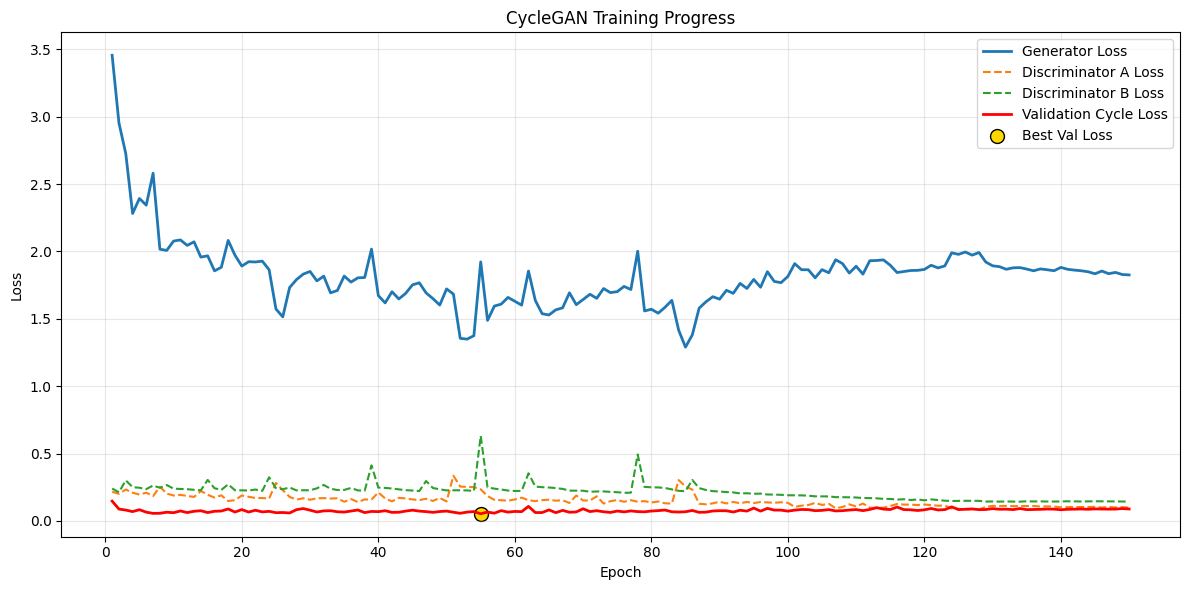

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load loss history CSV ---
loss_history = pd.read_csv("checkpoints/loss_history.csv")

# --- Plotting ---
plt.figure(figsize=(12, 6))

# Plot generator and discriminator losses
plt.plot(loss_history["epoch"], loss_history["G"], label="Generator Loss", linewidth=2)
plt.plot(loss_history["epoch"], loss_history["D_A"], label="Discriminator A Loss", linestyle="--")
plt.plot(loss_history["epoch"], loss_history["D_B"], label="Discriminator B Loss", linestyle="--")
plt.plot(loss_history["epoch"], loss_history["val_metric"], label="Validation Cycle Loss", color="red", linewidth=2)

# Highlight best epoch by minimum validation loss
best_epoch = loss_history.loc[loss_history["val_metric"].idxmin(), "epoch"]
best_val = loss_history["val_metric"].min()
plt.scatter([best_epoch], [best_val], color="gold", s=100, edgecolor='black', label="Best Val Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CycleGAN Training Progress")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [39]:
# --- Load the checkpoint for epoch 175 ---
checkpoint_path = "checkpoints/best_model.pth"
checkpoint = torch.load(checkpoint_path, map_location="cuda")

netG_A2B.load_state_dict(checkpoint['netG_A2B'])
netG_B2A.load_state_dict(checkpoint['netG_B2A'])
netG_A2B.eval()
netG_B2A.eval()

# --- Output folders for generated images ---
os.makedirs("results_A2B", exist_ok=True)
os.makedirs("results_B2A", exist_ok=True)

# --- Denormalization utility ---
def denorm(tensor):
    """Denormalize a tensor from [-1,1] to [0,1]."""
    return torch.clamp((tensor * 0.5) + 0.5, 0, 1)

# --- Inference and save results (A → B and B → A) ---
with torch.no_grad():
    for i, ((real_A, _), (real_B, _)) in enumerate(tqdm(zip(testloader_A, testloader_B), total=min(len(testloader_A), len(testloader_B)))):
        real_A = real_A.cuda()
        real_B = real_B.cuda()

        # A → B
        fake_B = netG_A2B(real_A)
        for j in range(fake_B.size(0)):
            save_image(denorm(fake_B[j]), f"results_A2B/fakeB_{i*testloader_A.batch_size+j:04d}.png")

        # B → A
        fake_A = netG_B2A(real_B)
        for j in range(fake_A.size(0)):
            save_image(denorm(fake_A[j]), f"results_B2A/fakeA_{i*testloader_B.batch_size+j:04d}.png")

print("Test results saved to results_A2B/ and results_B2A/.")

# --- Evaluate average cycle consistency loss on test set ---
cycle_loss = evaluate_on_validation(
    netG_A2B, netG_B2A, testloader_A, testloader_B, criterion_cycle, device="cuda"
)
print(f"Average cycle consistency loss on test set: {cycle_loss:.4f}")


100%|██████████| 75/75 [00:13<00:00,  5.58it/s]


Test results saved to results_A2B/ and results_B2A/.
Average cycle consistency loss on test set: 0.0897


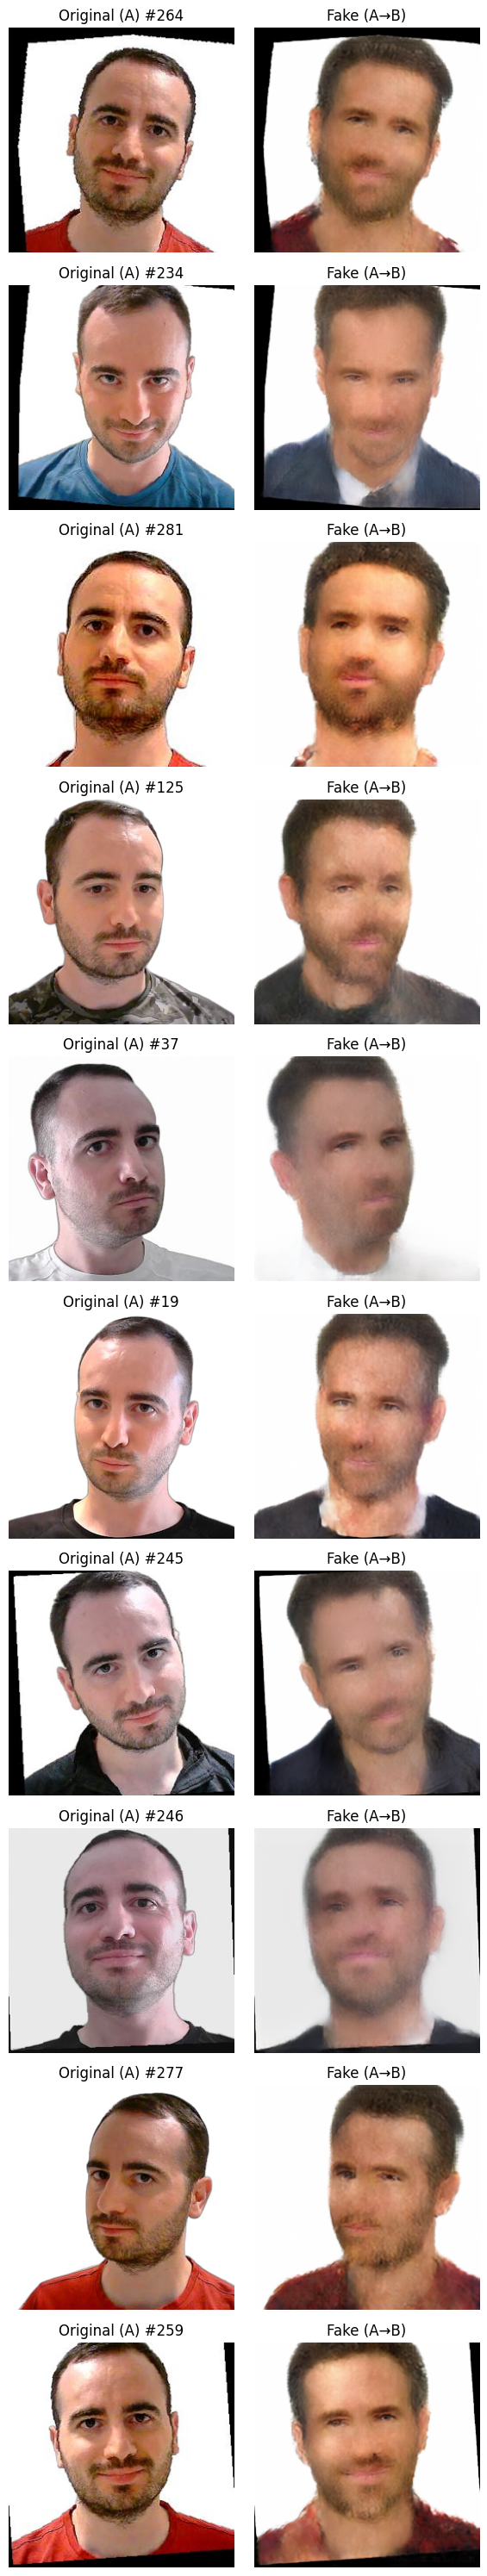

In [41]:
# --- Set model to evaluation mode ---
netG_A2B.eval()

# --- Randomly select 10 images from testset_A ---
n_samples = 10
indices = random.sample(range(len(testset_A)), n_samples)

# --- Denormalization function ---
def denorm(tensor):
    """Denormalize a tensor from [-1,1] to [0,1]."""
    return torch.clamp((tensor * 0.5) + 0.5, 0, 1)

# --- Inference and display ---
fig, axs = plt.subplots(n_samples, 2, figsize=(6, 3 * n_samples))

for i, idx in enumerate(indices):
    # Get original image and label
    img, _ = testset_A[idx]
    img_input = img.unsqueeze(0).cuda()

    # Run generator
    with torch.no_grad():
        fake_img = netG_A2B(img_input)

    # Denormalize for display
    img_orig_disp = denorm(img).cpu().permute(1,2,0).numpy()
    fake_img_disp = denorm(fake_img.squeeze()).cpu().permute(1,2,0).numpy()

    # Plot original and fake images side by side
    axs[i, 0].imshow(img_orig_disp)
    axs[i, 0].axis('off')
    axs[i, 0].set_title(f'Original (A) #{idx}')


    axs[i, 1].imshow(fake_img_disp)
    axs[i, 1].axis('off')
    axs[i, 1].set_title('Fake (A→B)')

plt.tight_layout()
plt.show()


In [16]:
# --- Load networks.py from CycleGAN repo ---
module_path = os.path.abspath('pytorch-CycleGAN-and-pix2pix/models/networks.py')
spec = importlib.util.spec_from_file_location("networks", module_path)
networks = importlib.util.module_from_spec(spec)
spec.loader.exec_module(networks)

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Instantiate your generator (as trained) ---
netG_A2B = networks.ResnetGenerator(
    input_nc=3, output_nc=3, ngf=64, use_dropout=False, n_blocks=9
).to(device)

# --- Load weights ---
model_path = "checkpoints/best_model.pth"
state = torch.load(model_path, map_location="cuda")
netG_A2B.load_state_dict(state['netG_A2B'])
netG_A2B.eval()

# --- Transform: must match train preprocessing ---
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

def denorm(tensor):
    """Inverse normalization: [-1,1] -> [0,1]"""
    return torch.clamp((tensor * 0.5) + 0.5, 0, 1)

# --- Initialize MediaPipe Face Detection ---
mp_face_detection = mp.solutions.face_detection
detector = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.7)

# --- Start webcam capture ---
cap = cv2.VideoCapture(0 )

if not cap.isOpened():
    print("Could not open webcam.")
    exit()

print("Press 'q' to quit.")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    h, w, _ = frame.shape
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = detector.process(rgb)

    # Default: display original frame and blank on right
    orig_disp = cv2.resize(frame, (256, 256))
    fake_disp = np.zeros_like(orig_disp)

    if results.detections:
        # Use first detected face
        bboxC = results.detections[0].location_data.relative_bounding_box
        x_min = int(bboxC.xmin * w)
        y_min = int(bboxC.ymin * h)
        bw = int(bboxC.width * w)
        bh = int(bboxC.height * h)
        # Expand box a bit for more context
        pad = int(0.2 * max(bw, bh))
        x1 = max(x_min - pad, 0)
        y1 = max(y_min - pad, 0)
        x2 = min(x_min + bw + pad, w)
        y2 = min(y_min + bh + pad, h)

        # Crop and process face
        face_crop = frame[y1:y2, x1:x2]
        if face_crop.shape[0] > 10 and face_crop.shape[1] > 10:
            face_rgb = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)
            input_img = transform(face_rgb).unsqueeze(0).to(device)

            with torch.no_grad():
                fake_img = netG_A2B(input_img)[0]

            fake_img = denorm(fake_img).cpu().numpy()
            fake_img = np.transpose(fake_img, (1, 2, 0))  # CHW -> HWC
            fake_img = (fake_img * 255).astype(np.uint8)
            fake_img = cv2.cvtColor(fake_img, cv2.COLOR_RGB2BGR)
            fake_img = cv2.resize(fake_img, (x2 - x1, y2 - y1))

            # Paste fake face to a copy of the original frame
            out_frame = frame.copy()
            out_frame[y1:y2, x1:x2] = fake_img

            # Display: left = crop original, right = crop fake
            orig_disp = cv2.resize(face_crop, (256, 256))
            fake_disp = cv2.resize(fake_img, (256, 256))
        else:
            out_frame = frame.copy()
    else:
        out_frame = frame.copy()

    # Show split screen: left = input face, right = generated
    output = np.concatenate([orig_disp, fake_disp], axis=1)
    cv2.imshow('Original (Left) | Translated (Right)', output)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Press 'q' to quit.


In [17]:
import torch
import cv2
import mediapipe as mp
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

model_path = "checkpoints/best_model.pth"
print("Model exists:", os.path.exists(model_path))

state = torch.load(model_path, map_location=device)
print("Loaded model keys:", state.keys())


Device: cuda
Model exists: True


C:\Users\יהונתן רבוח\AppData\Local\Temp\ipykernel_14000\1648671489.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path, map_location=device)


Loaded model keys: dict_keys(['epoch', 'netG_A2B', 'netG_B2A', 'netD_A', 'netD_B', 'optimizer_G', 'optimizer_D', 'scaler', 'loss_history'])
